<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/dehazenet_attention/dehazenet_withattention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:


# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img



In [18]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.1,validation_size=64,test_size=64,seed_val=101):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [19]:
def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val


In [20]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

## Network

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [22]:
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return tf.keras.layers.Conv2D(out_channels, kernel_size,padding='same', use_bias=bias)
    
class PixAtLayer(tf.keras.Model):
    def __init__(self, channel):
        super(PixAtLayer, self).__init__()
        self.pa = tf.keras.Sequential()
        self.pa.add(tf.keras.layers.Conv2D(channel // 8, 1, padding='valid',activation='relu'))
        self.pa.add(tf.keras.layers.Conv2D( 1, 1,activation='sigmoid'))
    def call(self, x):
        y = self.pa(x)
        #return y
        return x * y

    def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

def adapavgpooling(x,outsize):
    x_shape=tf.keras.backend.int_shape(x)
    batchsize1,dim1,dim2,channels1=x_shape
    stride=np.floor(dim1/outsize).astype(np.int32)
    kernels=dim1-(outsize-1)*stride
    adpooling=tf.keras.layers.AveragePooling2D(pool_size=(kernels,kernels),strides=(stride,stride))(x)
    
    return adpooling

class ChanAtLayer(tf.keras.Model):
  def __init__(self, channel):
      super(ChanAtLayer, self).__init__()
      #self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
      self.ca = tf.keras.Sequential()
      self.ca.add(tf.keras.layers.Conv2D(channel // 8, 1,activation='relu'))
      self.ca.add(tf.keras.layers.Conv2D(channel, 1, activation='sigmoid'))

  def call(self, x):
      y = adapavgpooling(x,1)
      y = self.ca(y)
      #return y
      return x * y

  def model(self):
        x = Input(shape = (412, 548, 64))
        return Model(inputs=[x], outputs=self.call(x))



In [23]:
sub = PixAtLayer(64)
sub.model().summary()
#sub1 = ChanAtLayer(64)
#sub1.model().summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 412, 548, 1)  41          input_3[0][0]                    
__________________________________________________________________________________________________
tf.math.multiply_2 (TFOpLambda) (None, 412, 548, 3)  0           input_3[0][0]                    
                                                                 sequential_5[0][0]               
Total params: 41
Trainable params: 41
Non-trainable params: 0
__________________________________________________________________________________________________


In [41]:
class dehazenet_attention(tf.keras.Model):
  def __init__(self):
    super(dehazenet_attention, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(input_shape = (412, 548, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv2 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv3 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv4 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv5 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv6 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv7 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.pa=PixAtLayer(64)
    self.ca=ChanAtLayer(64)
  def call(self, input_tensor, training=False):
      x1=self.conv1(input_tensor)
      x2=self.conv2(x1)
      concat1 = tf.concat([x1,x2], axis = -1)
      x3=self.conv3(concat1)
      concat2 = tf.concat([x2,x3], axis = -1)
      x4=self.conv4(concat2)
      concat3 = tf.concat([x1,x2,x3,x4], axis = -1)
      K=self.conv5(concat3)
      output1 = ReLU(max_value = 1.0)(tf.math.multiply(K,input_tensor) - K + 1.0)
      #x=self.conv6(output1)
      x=self.pa(output1)
      x=self.conv6(x)
      x=self.ca(x)
      output=self.conv7(x)
      return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))


In [42]:
sub = dehazenet_attention()
sub.model().summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 412, 548, 3)  12          input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 412, 548, 3)  84          conv2d_141[0][0]                 
__________________________________________________________________________________________________
tf.concat_15 (TFOpLambda)       (None, 412, 548, 6)  0           conv2d_141[0][0]                 
                                                                 conv2d_142[0][0]           

In [47]:
# Hyperparameters
epochs = 10
batch_size = 4
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = './drive/MyDrive/dataset/clear_images', hazy_img_path = './drive/MyDrive/dataset/haze')
#train_data, val_data = data_path()
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net =sub

#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

In [48]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [=====]  -  Training Loss: 0.0629

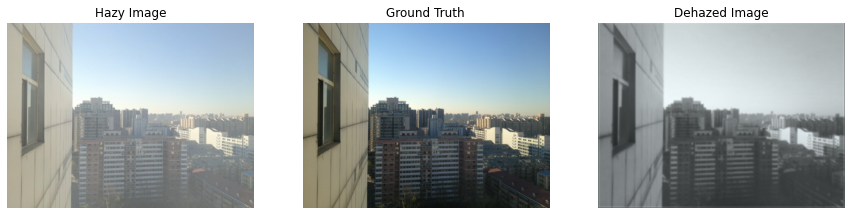

  -  Validation Loss: 0.0143  -   Time taken: 63.32s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 1 [=====]  -  Training Loss: 0.0132

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


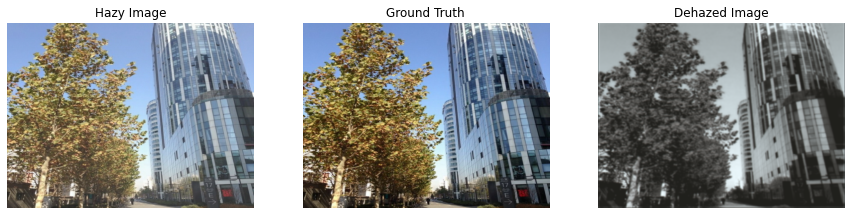

  -  Validation Loss: 0.0134  -   Time taken: 63.34s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 2 [=====]  -  Training Loss: 0.0123

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


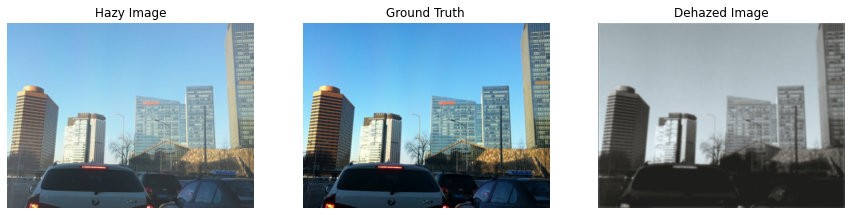

  -  Validation Loss: 0.0122  -   Time taken: 63.58s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 3 [=====]  -  Training Loss: 0.0116

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


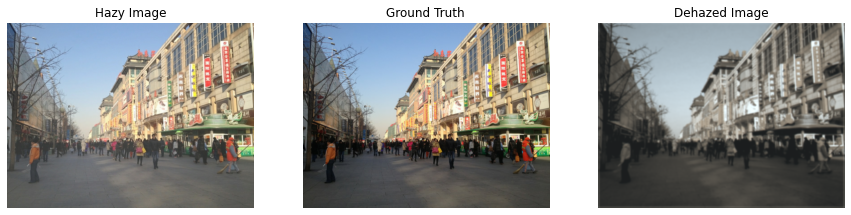

  -  Validation Loss: 0.0113  -   Time taken: 63.38s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 4 [=====]  -  Training Loss: 0.0110

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


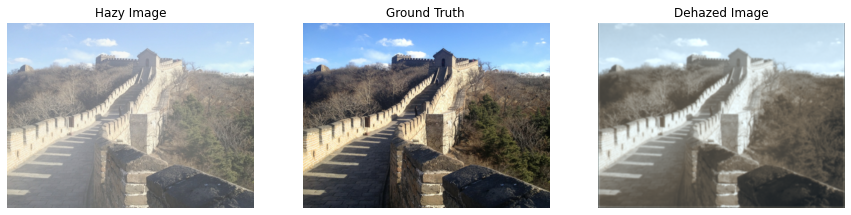

  -  Validation Loss: 0.0109  -   Time taken: 63.32s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 5 [=====]  -  Training Loss: 0.0103

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


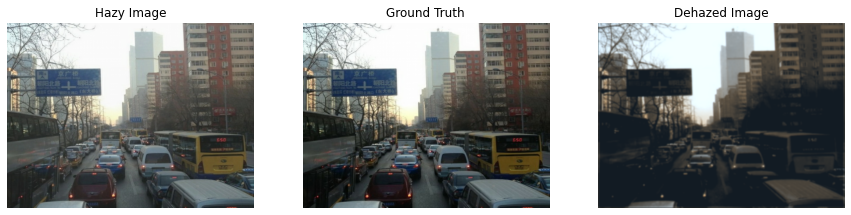

  -  Validation Loss: 0.0100  -   Time taken: 63.31s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 6 [=====]  -  Training Loss: 0.0099

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


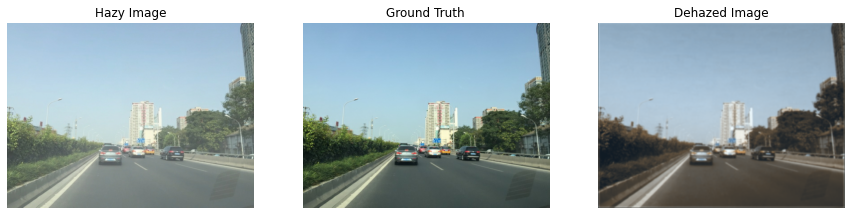

  -  Validation Loss: 0.0096  -   Time taken: 63.95s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 7 [=====]  -  Training Loss: 0.0096

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


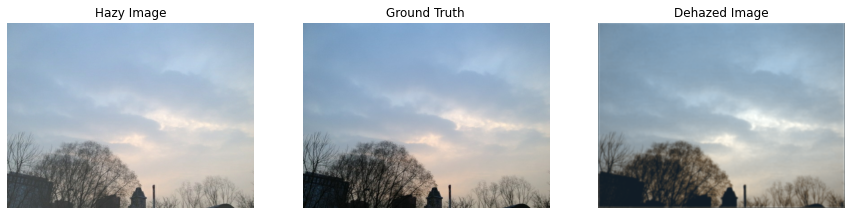

  -  Validation Loss: 0.0090  -   Time taken: 63.98s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 8 [=====]  -  Training Loss: 0.0093

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


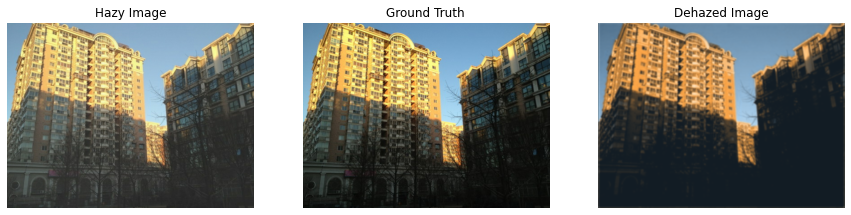

  -  Validation Loss: 0.0088  -   Time taken: 63.43s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 9 [=====]  -  Training Loss: 0.0092

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


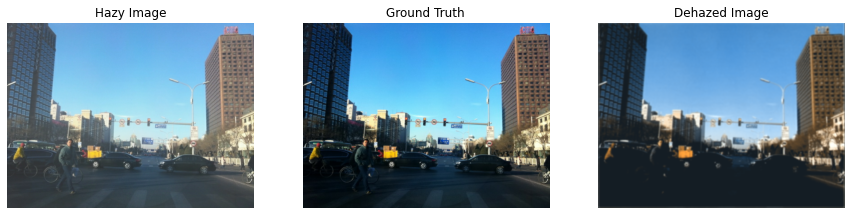

  -  Validation Loss: 0.0087  -   Time taken: 63.37s
INFO:tensorflow:Assets written to: trained_model/assets
CPU times: user 6min 29s, sys: 26.3 s, total: 6min 56s
Wall time: 10min 56s


In [49]:


%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)



In [ ]:
import torch.nn as nn
import torch

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size,padding=(kernel_size//2), bias=bias)
    
class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y

class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size,):
        super(Block, self).__init__()
        self.conv1=conv(dim, dim, kernel_size, bias=True)
        self.act1=nn.ReLU(inplace=True)
        self.conv2=conv(dim,dim,kernel_size,bias=True)
        self.calayer=CALayer(dim)
        self.palayer=PALayer(dim)
    def forward(self, x):
        res=self.act1(self.conv1(x))
        res=res+x 
        res=self.conv2(res)
        res=self.calayer(res)
        res=self.palayer(res)
        res += x 
        return res
class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [ Block(conv, dim, kernel_size)  for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)
    def forward(self, x):
        res = self.gp(x)
        res += x
        return res

class FFA(nn.Module):
    def __init__(self,gps,blocks,conv=default_conv):
        super(FFA, self).__init__()
        self.gps=gps
        self.dim=64
        kernel_size=3
        pre_process = [conv(3, self.dim, kernel_size)]
        assert self.gps==3
        self.g1= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g2= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g3= Group(conv, self.dim, kernel_size,blocks=blocks)
        self.ca=nn.Sequential(*[
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim*self.gps,self.dim//16,1,padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim//16, self.dim*self.gps, 1, padding=0, bias=True),
            nn.Sigmoid()
            ])
        self.palayer=PALayer(self.dim)

        post_precess = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)]

        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_precess)

    def forward(self, x1):
        x = self.pre(x1)
        res1=self.g1(x)
        res2=self.g2(res1)
        res3=self.g3(res2)
        w=self.ca(torch.cat([res1,res2,res3],dim=1))
        w=w.view(-1,self.gps,self.dim)[:,:,:,None,None]
        out=w[:,0,::]*res1+w[:,1,::]*res2+w[:,2,::]*res3
        out=self.palayer(out)
        x=self.post(out)
        return x + x1

In [40]:
import torch.nn as nn
import torch

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size,padding=(kernel_size//2), bias=bias)
    
class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y

class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

In [46]:
from torchsummary import summary
net=PALayer(64)
#if torch.cuda.is_available():
#    net.cuda()
print(summary(net, (3, 224, 224)))

RuntimeError: ignored

In [ ]:

from torchsummary import summary
model=FFA(3,19)

In [ ]:
net=FFA(gps=3,blocks=1)
print(net)

FFA(
  (g1): Group(
    (gp): Sequential(
      (0): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (calayer): CALayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (ca): Sequential(
            (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
            (3): Sigmoid()
          )
        )
        (palayer): PALayer(
          (pa): Sequential(
            (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
            (3): Sigmoid()
          )
        )
      )
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (g2): Group(
    (gp): Sequential(
      (

In [ ]:
net=FFA(gps=3,blocks=11)
if torch.cuda.is_available():
    net.cuda()
print(summary(net, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]             520
              ReLU-7              [-1, 8, 1, 1]               0
            Conv2d-8             [-1, 64, 1, 1]             576
           Sigmoid-9             [-1, 64, 1, 1]               0
          CALayer-10         [-1, 64, 224, 224]               0
           Conv2d-11          [-1, 8, 224, 224]             520
             ReLU-12          [-1, 8, 224, 224]               0
           Conv2d-13          [-1, 1, 224, 224]               9
          Sigmoid-14          [-1, 1, 2